To show the influence of various factors on BaPHQ8, I first used a Random Forest model. However, the small sample size led to overfitting, and the model didn’t generalize well. So, I switched to a Spearman correlation analysis, which gave a clearer understanding of how different variables relate to BaPHQ8, avoiding the overfitting issues of the Random Forest model.

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tot

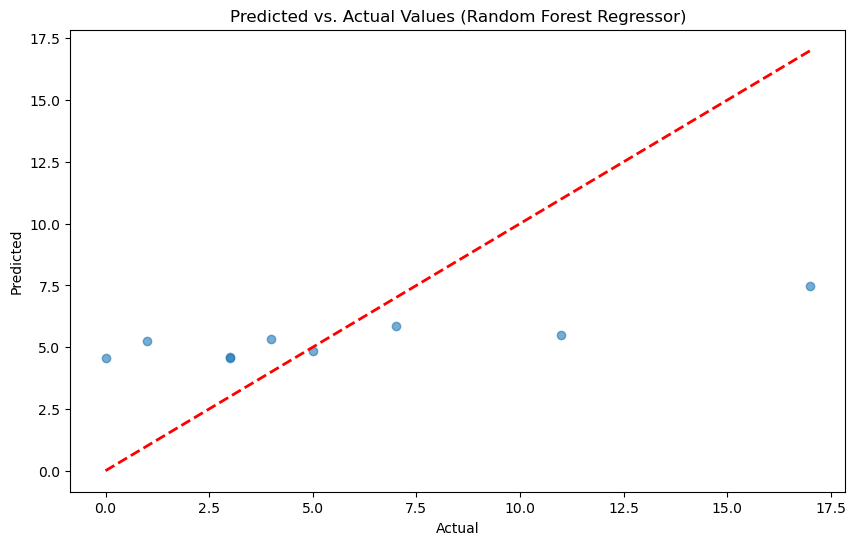

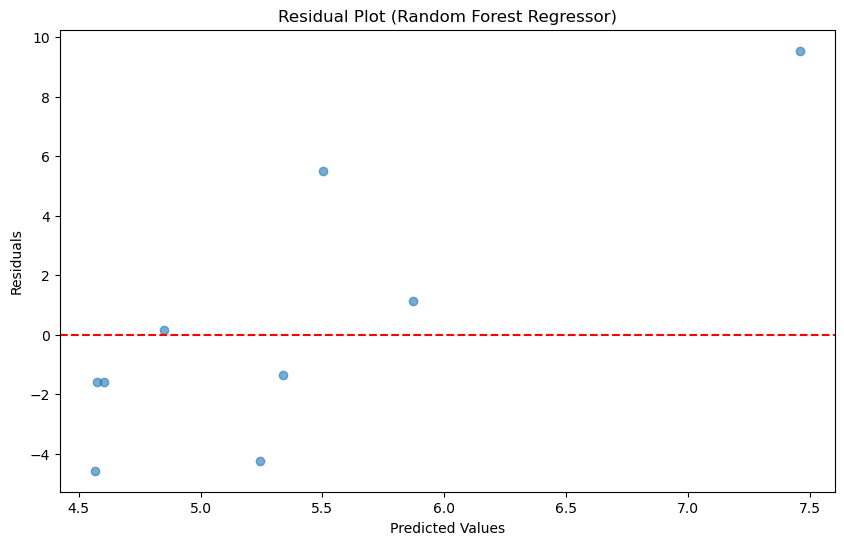

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

file_path = '/Users/nijat/Desktop/Diet.xlsx' 
df = pd.read_excel(file_path)

df_numeric = df.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.drop(columns=['BaGAD7'])

imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

X = df_imputed.drop(columns=['BaPHQ8'])
y = df_imputed['BaPHQ8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, verbose=0)

print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"R-squared (R²): {r2_rf}")
print(f"Mean Cross-Validation R² Score: {cv_scores_rf.mean()}")
print(f"Standard Deviation of Cross-Validation R² Scores: {cv_scores_rf.std()}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values (Random Forest Regressor)')
plt.show()

residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest Regressor)')
plt.show()


The Random Forest model results show moderate performance on the test data, with an R-squared value of 0.268 and a Root Mean Squared Error (RMSE) of 4.324. However, the negative mean cross-validation R-squared score (-1.387) indicates significant struggles with generalization, likely worsened by the low sample size, which can limit the model's ability to capture broader patterns in the data.

The high standard deviation in cross-validation scores (2.361) further shows the model's instability and potential overfitting, where it appears to capture noise rather than meaningful trends. The limited sample size contributes to this overfitting, making the model unreliable for real-world applications where it may encounter more diverse data.

In [42]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer

file_path = '/Users/nijat/Desktop/Diet.xlsx'
df = pd.read_excel(file_path)

df_numeric = df.apply(pd.to_numeric, errors='coerce')

imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

X = df_imputed.drop(columns=['BaPHQ8'])
y = df_imputed['BaPHQ8']

data_with_target = X.copy()
data_with_target['BaPHQ8'] = y

correlations = {}
for column in data_with_target.columns:
    if column != 'BaPHQ8':
        correlation, _ = spearmanr(data_with_target[column], data_with_target['BaPHQ8'])
        correlations[column] = correlation

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Spearman Correlation'])
correlation_df = correlation_df.sort_values(by='Spearman Correlation', ascending=False)

correlation_df.head(10)


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,Feature,Spearman Correlation
1,BaGAD7,0.857018
8,Steroids,0.391543
62,V_STARCHY_TOTAL,0.358001
63,V_STARCHY_POTATO,0.347686
73,PF_CUREDMEAT,0.298886
71,PF_MPS_TOTAL,0.286356
36,ACAR,0.276833
2,BaFCP,0.270361
86,SOLID_FATS,0.265680
74,PF_POULT,0.265468


The Spearman correlation analysis identified BaGAD7 as having the strongest correlation with BaPHQ8 (ρ = 0.857), indicating a strong association between these two psychological variables. Additionally, Steroids (ρ = 0.392) and V_STARCHY_TOTAL (ρ = 0.358) also showed moderate correlations with BaPHQ8, suggesting that both medication use and dietary starch intake are related to BaPHQ8 scores.